In [ ]:
!  pip install -q tensorflow-model-optimization

In [11]:
import tempfile
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from tensorflow.keras.optimizers import Adam
import  argparse
from utils import dataset
from utils import display_sample,show_predictions,create_mask
from Models import unetModel
import os
import datetime
import numpy as np
from losses import custom_sparse_weighted_crossentropy

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Build and evaluate base model

In [12]:
BATCH_SIZE=3
EPOCHS = 100
ClASSES=5 # Backgroud plus four lanes
lr=0.0001

In [13]:
data="/media/asad/8800F79D00F79104/lanes_data/20k_images/"
labels="/media/asad/8800F79D00F79104/lanes_data/20k_labels/"
lane_data=dataset(data,labels)
datasets=lane_data.load_dataset()

The Training Dataset contains 20000 images.
The Training labels contains 20000 images.
Training size 19000
Validation size 1000


2


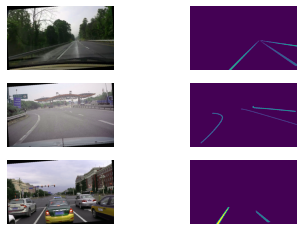

In [14]:
data=list(datasets["train"].take(1).as_numpy_iterator())
sample_image,sample_label=data[0][0],data[0][1]
display_sample([sample_image,sample_label])

In [15]:
model=unetModel()
unet=model.get_unet()
unet.trainable=True
unet.load_weights("/media/asad/8800F79D00F79104/best_unet_lane_20k_default_ce.h5")
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=Adam(learning_rate=lr), loss =loss,metrics=['accuracy'])   

In [16]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 24, 40, 512)  1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_8[0][0]               
                                                                 model_2[1][3]              

In [17]:
val_steps=lane_data.val_size//BATCH_SIZE
train_steps=lane_data.train_size//BATCH_SIZE

In [21]:
_, baseline_model_accuracy = unet.evaluate(datasets["val"],steps=val_steps, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(unet, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9923388361930847
Saved baseline model to: /tmp/tmprd6d1ydu.h5


In [22]:
os.path.getsize(keras_file )*1e-6

26.350032

## Apply Pruning on base model

In [23]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = BATCH_SIZE
epochs = 1

num_images = lane_data.val_size
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_upsample(layer):
  if isinstance(layer, tf.keras.layers.Conv2DTranspose) or isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)

  if isinstance(layer, tf.keras.Sequential):
        #print("Entered Sequential")
        all_layers=[]
        for l in layer.layers:
            if isinstance(l, tf.keras.layers.Conv2DTranspose) or isinstance(l, tf.keras.layers.Conv2D):
                all_layers.append(tfmot.sparsity.keras.prune_low_magnitude(l,**pruning_params))
            else:
                all_layers.append(l)
        return tf.keras.Sequential(all_layers)
  return layer

model_for_pruning = tf.keras.models.clone_model(unet,clone_function=apply_pruning_to_upsample)


# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

model_for_pruning.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 24, 40, 512)  2951170     model_2[2][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_12[0][0]              
                                                                 model_2[2][3]              

In [25]:
# Check if the sparsity is applied to the sequential layer
#layers= model_for_pruning.get_layer("sequential_5")
#for layer in layers.layers:
#    print(layer)

ValueError: No such layer: sequential_5

In [26]:
from tensorflow_model_optimization.python.core.sparsity.keras.pruning_wrapper import PruneLowMagnitude
to_be_pruned=0
names=[]
for layer in model_for_pruning.layers:
    if (isinstance(layer,PruneLowMagnitude)):
        to_be_pruned+=1
        names.append(layer.name)
print(f"Total layers to be pruned: {to_be_pruned}")
print(f"Pruned Layers: {names}")

Total layers to be pruned: 1
Pruned Layers: ['prune_low_magnitude_conv2d_transpose_9']


In [27]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(datasets["train"],batch_size=batch_size,epochs=epochs, steps_per_epoch=train_steps,validation_steps=val_steps,validation_data=datasets['val'],callbacks=callbacks)

6333/6333 [==============================] - 929s 147ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.0324 - val_accuracy: 0.9881


In [28]:
def save_model_file(model):
  _, keras_file = tempfile.mkstemp('.h5') 
  model.save(keras_file, include_optimizer=False)
  return keras_file

def get_gzipped_model_size(model):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile

  keras_file = save_model_file(model)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)
  return os.path.getsize(zipped_file)*1e-6

In [29]:
_, keras_model_file = tempfile.mkstemp('.h5')

# Checkpoint: saving the optimizer is necessary (include_optimizer=True is the default).
model_for_pruning.save(keras_model_file, include_optimizer=True)
print(keras_model_file)

/tmp/tmpl77tfkg5.h5


In [ ]:
#with tfmot.sparsity.keras.prune_scope():
#    loaded_model = tf.keras.models.load_model(keras_model_file)


In [ ]:
#from tensorflow_model_optimization.python.core.sparsity.keras.pruning_wrapper import PruneLowMagnitude
#type(loaded_model.layers[-1]).__name__
#with tfmot.sparsity.keras.prune_scope():
#    print(isinstance(loaded_model.layers[-1],PruneLowMagnitude))

In [30]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [31]:
model_for_export.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 24, 40, 512)  1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_12[0][0]              
                                                                 model_2[1][3]              

In [ ]:
#Check that the spatsity is removed from sequential layers
#layers= model_for_export.get_layer("sequential_5")
#for layer in layers.layers:
#    print(layer)

In [32]:
print("\n")
print("Size of gzipped pruned model without stripping: %.2f MB" % (get_gzipped_model_size(model_for_pruning)))
print("Size of gzipped pruned model with stripping: %.2f MB" % (get_gzipped_model_size(model_for_export)))



Size of gzipped pruned model without stripping: 13.37 MB
Size of gzipped pruned model with stripping: 12.49 MB


In [33]:
_, striped_model_file = tempfile.mkstemp('.h5')
model_for_export.save(striped_model_file, include_optimizer=False)
#model_for_export.save("pruned.h5",include_optimizer=True)


In [34]:
striped_loaded_model=tf.keras.models.load_model(striped_model_file)
#striped_loaded_model=tf.keras.models.load_model("pruned.h5")

In [35]:
striped_loaded_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 24, 40, 512)  1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_12[0][0]              
                                                                 model_2[1][3]              

In [ ]:
#for layer in striped_loaded_model.get_layer("sequential_4").layers:
#    print(layer)

In [ ]:
#converter = tf.lite.TFLiteConverter.from_keras_model(striped_loaded_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tflite_quant_model = converter.convert()

#_, quantized_tflite_file = tempfile.mkstemp('.tflite')

#with open(quantized_tflite_file, 'wb') as f:
#  f.write(tflite_quant_model)

## Apply Clustering to the Pruned Model

In [36]:
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
clustering_params = {
  'number_of_clusters': 3,
  'cluster_centroids_init': CentroidInitialization.DENSITY_BASED
}

def apply_clustering_to_upsample(layer):    
  if isinstance(layer, tf.keras.layers.Conv2DTranspose) or isinstance(layer, tf.keras.layers.Conv2D):
      return tfmot.clustering.keras.cluster_weights(layer,**clustering_params)

  if isinstance(layer, tf.keras.Sequential):
        print("Entered Sequential")
        all_layers=[]
        for l in layer.layers:
            if isinstance(l, tf.keras.layers.Conv2DTranspose) or isinstance(l, tf.keras.layers.Conv2D):
                all_layers.append(tfmot.clustering.keras.cluster_weights(l,**clustering_params))
            else:
                all_layers.append(l)
        return tf.keras.Sequential(all_layers)
  return layer


In [37]:
clustered_model = tf.keras.models.clone_model(striped_loaded_model,clone_function=apply_clustering_to_upsample)

Entered Sequential
Entered Sequential
Entered Sequential
Entered Sequential


In [38]:
clustered_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])
clustered_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 24, 40, 512)  1476611     model_2[2][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_16[0][0]              
                                                                 model_2[2][3]              

In [39]:
clustered_model.fit(datasets["train"],batch_size=batch_size,epochs=epochs, steps_per_epoch=train_steps,validation_steps=val_steps,validation_data=datasets['val'])

6333/6333 [==============================] - 1531s 242ms/step - loss: 0.2639 - accuracy: 0.9704 - val_loss: 0.0879 - val_accuracy: 0.9771


In [40]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 24, 40, 512)  1476611     model_2[3][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_16[1][0]              
                                                                 model_2[3][3]              

In [39]:
with tfmot.clustering.keras.cluster_scope():
     final_model= tf.keras.models.load_model("/tmp/tmprd22o3o8.h5")

In [42]:
final_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
final_model = tfmot.clustering.keras.strip_clustering(final_model)
#i=0
with tfmot.clustering.keras.cluster_scope():
    def strip_clustering(layer):
        if isinstance(layer, tf.keras.Sequential):    
            print("Striped Clustering Sequential")
            #i+1
            return tfmot.clustering.keras.strip_clustering(layer)
        else:
            return layer
final_model_2 = tf.keras.models.clone_model(final_model,clone_function=strip_clustering)

Striped Clustering Sequential
Striped Clustering Sequential
Striped Clustering Sequential
Striped Clustering Sequential


In [46]:
final_model_2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
_, cluster_model_accuracy = final_model_2.evaluate(datasets["val"],steps=val_steps, verbose=0)

print('Baseline test accuracy:',  cluster_model_accuracy)

Baseline test accuracy: 0.9777037501335144


In [50]:
print(final_model_2.summary())
for layer in final_model_2.get_layer("sequential_19").layers:
    print(layer)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 24, 40, 512)  1476608     model_2[6][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_16[0][0]              
                                                                 model_2[6][3]              

In [48]:
print("Size of gzipped Original Model: %.2f MB" % (get_gzipped_model_size(unet)))
print("Size of gzipped pruned model with stripping: %.2f MB" % (get_gzipped_model_size(model_for_export)))
print("Size of gzipped clustered model with stripping: %.2f Megabytes" % (get_gzipped_model_size(final_model)))

Size of gzipped Original Model: 12.49 MB
Size of gzipped pruned model with stripping: 12.49 MB
Size of gzipped clustered model with stripping: 7.91 Megabytes


In [51]:
_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model_2, clustered_keras_file, include_optimizer=False)

Saving clustered model to:  /tmp/tmpy2yt5a_u.h5


In [52]:
striped_clustered_model=tf.keras.models.load_model(clustered_keras_file)

In [53]:
striped_clustered_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 192, 320, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 24, 40, 512)  1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 24, 40, 1088) 0           sequential_16[0][0]              
                                                                 model_2[1][3]              

In [49]:
with tfmot.clustering.keras.cluster_scope():
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model_2)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()

    _, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

    with open(quantized_and_clustered_tflite_file, 'wb') as f:
      f.write(tflite_quant_model)

ConverterError: See console for info.
2021-03-01 01:34:21.780839: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:144] Ignored output_format.
2021-03-01 01:34:21.807030: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:147] Ignored drop_control_dependency.
2021-03-01 01:34:22.045187: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2
2021-03-01 01:34:22.281853: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3499910000 Hz
2021-03-01 01:34:22.288463: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e1b9231a60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-01 01:34:22.288535: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-03-01 01:34:22.361403: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-01 01:34:22.515255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:22.516141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.607GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-03-01 01:34:22.529708: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-01 01:34:22.765768: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-01 01:34:22.918251: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-03-01 01:34:22.981574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-03-01 01:34:23.472529: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-03-01 01:34:23.525988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-03-01 01:34:24.011362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-03-01 01:34:24.011703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:24.012801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:24.013580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1703] Adding visible gpu devices: 0
2021-03-01 01:34:24.013714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-01 01:34:24.285523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-03-01 01:34:24.285574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      0 
2021-03-01 01:34:24.285589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1121] 0:   N 
2021-03-01 01:34:24.296442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:24.297491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:24.298379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-01 01:34:24.299128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1247] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 8 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1)
2021-03-01 01:34:24.324860: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e1bc97dc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-03-01 01:34:24.324939: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce GTX 1080 Ti, Compute Capability 6.1
2021-03-01 01:34:35.159478: F ./tensorflow/core/kernels/conv_2d_gpu.h:970] Non-OK-status: GpuLaunchKernel( SwapDimension1And2InTensor3UsingTiles<T, kNumThreads, kTileSize, kTileSize, conjugate>, total_tiles_count, kNumThreads, 0, d.stream(), input, input_dims, output) status: Internal: out of memory
Fatal Python error: Aborted

Current thread 0x00007f7152f54740 (most recent call first):
  File "/home/asad/anaconda/envs/tf2/lib/python3.6/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 56 in execute
  File "/home/asad/anaconda/envs/tf2/lib/python3.6/site-packages/absl/app.py", line 251 in _run_main
  File "/home/asad/anaconda/envs/tf2/lib/python3.6/site-packages/absl/app.py", line 303 in run
  File "/home/asad/anaconda/envs/tf2/lib/python3.6/site-packages/tensorflow/python/platform/app.py", line 40 in run
  File "/home/asad/anaconda/envs/tf2/lib/python3.6/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 93 in main
  File "/home/asad/anaconda/envs/tf2/bin/toco_from_protos", line 11 in <module>
Aborted (core dumped)


